In [110]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import math
from memory_profiler import profile 
import numpy as np

In [5]:
# This script will train a neural network to identify numbers from images taken 
# from zip codes written on envelopes from the USPS. 
# 
# Tasks: 
# 1) Import the training and test data 
# 2) Plot a few candidate data points 
# 3) Build a convolutional neural net model to train on the test data 
# 4) Inspect the training and test losses 
# 5) Observe error rate and error rate, given a particular rejection rate. 
# 6) Observe the activation and gradient statistics of the model
# 7) Sample the model. 

In [61]:
Xtr, Xte = [], []
Ytr, Yte = [], []

with open("dataset/zip.train", 'r') as f: 
    dataset = f.read().splitlines()
    for data in dataset: 
        data = data.split()
        Ytr.append(int(float(data[0])))
        Xtr.append([float(d) for d in data[1:]])
    Ytr = torch.tensor(Ytr)
    Xtr = torch.tensor(Xtr)
    Xtr = Xtr.view(Xtr.shape[0], 1, 16, 16)   # format as a 4D column as expected by Conv2d
    
with open("dataset/zip.test", "r") as f: 
    dataset = f.read().splitlines()
    for data in dataset: 
        data = data.split()
        Yte.append(int(float(data[0])))
        Xte.append([float(d) for d in data[1:]])
    Yte = torch.tensor(Yte)
    Xte = torch.tensor(Xte)
    Xte = Xte.view(Xte.shape[0], 1, 16, 16)   # format as a 4D column as expected by Conv2d

print(f"Training Data Length = {len(Xtr)}, Test Data Length = {len(Xte)}")

Training Data Length = 7291, Test Data Length = 2007


Examples from the Training Set


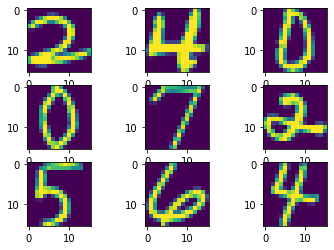

In [63]:
print("Examples from the Training Set")
fig, axs = plt.subplots(3,3)
ix = torch.randint(0, Xtr.shape[0], (9, ))
i = 0
for row in axs: 
    for col in row: 
        col.imshow(Xtr[ix[i]].squeeze())
        i += 1

In [650]:
 # Create Layer, BatchNorm, Tanh classes

# ------------------------------------------------------------------------------
class Linear: 
    def __init__(self, fanin, fanout, bias=False):
        self.weight = torch.randn([fanin, fanout]) / (fanin**0.5)
        self.bias = torch.zeros(fanout) if bias else None
    
    def __repr__(self):
        return f"Linear({tuple(self.weight.shape)})"
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            return self.out + self.bias
        else: 
            return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------
class BatchNorm1d: 
    def __init__(self, num_features, momentum=0.1, eps=1e-5, track_running_stats=True):
        # dim is the number of examples used in the batch 
        self.momentum = momentum 
        self.track_running_stats = track_running_stats
        self.num_features = num_features 
        self.eps = eps
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features) 
    
    def __repr__(self):
        return f"BatchNorm1d[(num_features={self.num_features}, momentum={self.momentum}) | track_running_stats={self.track_running_stats}]"
    
    def __call__(self, x): 
        if self.track_running_stats: 
            if x.ndim == 2: 
                dim = 0
            elif x.ndim == 3: 
                dim = (0, 1)
            xmean = x.mean(dim, keepdims=True)
            xvar = x.var(dim, keepdims=True, correction=1) # bessel's correction 
            
            self.out = self.gamma * (x - xmean) * (xvar + self.eps) ** (-0.5) + self.beta
            with torch.no_grad(): 
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1-self.momentum) * self.running_var
            
        else: 
            self.out = self.gamma * (x - self.running_mean) * (self.running_var + self.eps) ** (-0.5) + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# ------------------------------------------------------------------------------
class BatchNorm2d: 
    """
    BatchNorm2d function written specifically for a 4D input (such as convolution neural nets)
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, track_running_stats=True): 
        self.momentum = momentum 
        self.track_running_stats = track_running_stats
        self.num_features = num_features 
        self.eps = eps
        self.gamma = torch.ones(num_features, 1, 1)
        self.beta = torch.zeros(num_features, 1, 1)
        self.running_mean = torch.zeros(num_features, 1, 1)
        self.running_var = torch.ones(num_features, 1, 1) 
    
    def __repr__(self):
        return f"BatchNorm1d[(num_features={self.num_features}, momentum={self.momentum}) | track_running_stats={self.track_running_stats}]"
    
    def __call__(self, x): 
        if self.track_running_stats: 
            xmean = x.mean((0, 2, 3), keepdims=True)
            xvar = x.var((0, 2, 3), keepdims=True)
            
            self.out = self.gamma * (x - xmean) * (xvar + self.eps)**(-0.5) + self.beta
            
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean 
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
            
        else: 
            self.out = self.gamma * (x - self.running_mean) * (self.running_var + self.eps) ** (-0.5) + self.beta
            
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
# ------------------------------------------------------------------------------
class Tanh:
    def __repr__(self):
        return f"Tanh"
    
    def __call__(self, x): 
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
# ------------------------------------------------------------------------------
class Relu:
    def __repr__(self):
        return f"Relu"
    
    def __call__(self, x): 
        self.out = (x > 0) * x
        return self.out
    
    def parameters(self):
        return []
    
# ------------------------------------------------------------------------------
class Conv2d: 
    def __init__(self, channels_in, channels_out, kernel_size, stride, padding, bias=True): 
        self.channels_in = channels_in
        self.channels_out = channels_out
        self.kernel_size = kernel_size
        self.padding = padding
        if isinstance(self.padding, int): 
            self.padding = (padding, padding)   # symmetrical padding is required 
        self.stride = stride
        if isinstance(self.stride, int): 
            self.stride = (stride, stride)
        if isinstance(self.kernel_size, int): 
            self.kernel_size = (kernel_size, kernel_size)
        
        fanin = channels_in * math.prod(kernel_size)
        self.weight = torch.randn(channels_out, self.kernel_size[0] * self.kernel_size[1] * channels_in) / (fanin)**0.5
        self.bias = torch.randn(channels_out, 1, 1) / (fanin)**0.5 if bias else None
        
    def __repr__(self):
        return f"Conv2d({self.channels_in}ch_in, {self.channels_out}ch_out, {self.kernel_size} kernel_size, {self.stride} stride, {self.padding} padding)"
    
    @property
    def bias(self):
        return self._bias
    
    @bias.setter
    def bias(self, bias): 
        if bias:
            assert len(bias) == self.channels_out
            self._bias = bias.view(self.channels_out, 1, 1)
        else:
            self._bias = None
    
    def __call__(self, x):
        batch_size = x.shape[0]
        out_shape_width = (x.shape[-1] + (2*self.padding[1]) - self.kernel_size[1])/(self.stride[1]) + 1
        out_shape_height = (x.shape[-2] + (2*self.padding[0]) - self.kernel_size[0])/(self.stride[0]) + 1
        
        assert out_shape_width.is_integer(), "Combination of input volume, kernel_size, padding, and stride not acceptable in width dimension"
        assert out_shape_height.is_integer(), "Combination of input volume, kernel_size, padding, and stride not acceptable in height dimension"
        
        out_shape_width = int(out_shape_width)
        out_shape_height = int(out_shape_height)
        
        input_col = self.im2col(x)
        weights_row = self.weight.view(self.channels_out, self.kernel_size[0] * self.kernel_size[1] * self.channels_in)
#         print(f"input_col output {tuple(input_col.shape)}:")
#         print(f"x={x}")
#         print(f"input_col = {input_col.T}")
#         print(f"weights_row matrix {tuple(weights_row.shape)}:")
#         print(f"self.weight = {self.weight}")
#         print(f"weights_row = {weights_row}")
        self.out = (weights_row @ input_col.T)
        self.out = self.out.permute(*torch.arange(self.out.ndim - 1, -1, -1))    # reverse the shape so that the resulting view operation produces correct result
        self.out = self.out.view(batch_size, self.channels_out, out_shape_height, out_shape_width)
        self.out = self.out + self.bias if self.bias is not None else self.out
        return self.out
        
    def im2col(self, x):
        """
        Our own version of im2col to make efficient conv2d.
        Input: input tensor to unfold 
        Output: 3D tensor (N, C, L) where N is batch size, C is channels_in * self.kernel_size[0] * self.kernel_size[1], and L is how many blocks exist while sliding over a single input slice 
        """
        unfold = torch.nn.Unfold(self.kernel_size, 1, self.padding, self.stride)
        output = unfold(x)
        return output
        
    def parameters(self): 
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------
class MaxPool2d:
    def __init__(self, kernel_size, stride, padding): 
        self.kernel_size = kernel_size
        if isinstance(stride, int): 
            self.stride = (stride, stride)
        if isinstance(padding, int): 
            self.padding = (padding, padding)
    
    def __repr__(self): 
        return f"Pooling(kernel_size = {self.kernel_size}, stride = {self.stride}, padding = {self.padding})"
    
    def __call__(self, x): 
        x_pad = F.pad(x, self.padding)
        pools = []
        
        size_x = (x_pad.shape[-1] + 2 * self.padding[1] - self.kernel_size[1])/(self.stride[1]) + 1
        size_y = (x_pad.shape[-2] + 2 * self.padding[0] - self.kernel_size[0])/(self.stride[0]) + 1
        
        assert size_x.is_integer(), "Combination of kernel_size, stride, and padding is invalid for pooling width"
        assert size_y.is_integer(), "Combination of kernel_size, stride, and padding is invalid for pooling height"
        
        size_x = int(size_x)
        size_y = int(size_y)
        
        self.out = torch.zeros(x.shape[0], x.shape[1], size_y, size_x)
        
        for a in range(self.out.shape[0]):
            for b in range(self.out.shape[1]):
                for c in range(size_y):
                    for d in range (size_x): 
                        pool = x_pad[a, b, c * kernel_size[0] : (c+1) * kernel_size[0], d*kernel_size[1] : (d+1) * kernel_size[1]]
                        self.out[a,b,c,d] = torch.max(pool)
        
        return self.out
    
    def parameters(self): 
        return []
    
    
# ------------------------------------------------------------------------------
class Embedding: 
    def __init__(self, num_embedding, dim_embedding): 
        self.weight = torch.randn([num_embedding, dim_embedding])
    
    def __repr__(self):
        return f"Embedding({tuple(self.weight.shape)})"
    
    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# ------------------------------------------------------------------------------
class Flatten: 
    """
    Flattens the input matrix outside of the batch dimension (first dimension)
    """
    def __call__(self, x): 
        self.out = x.reshape(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
    def __repr__(self):
        return f"Flatten()"
    
# ------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x): 
        B, T, C = x.shape
        x = x.view(B, T//self.n, self.n*C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x 
        return self.out
    
    def parameters(self):
        return []
    
    def __repr__(self):
        return f"FlattenConsecutive({self.n})"
    
# ------------------------------------------------------------------------------
class Sequential: 
    def __init__(self, layers): 
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # return parameters for all parameters in each layer
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"Sequential({self.layers})"
    
    def append(self, layer): 
        self.layers.append(layer)

In [809]:
# Test Conv2d Class
batch_size = 1
channels_in = 2
channels_out = 2
input_vol_temp = torch.tensor(np.linspace(1,16,16),  dtype=torch.float).view(1, 1, 4, 4)
input_vol = torch.zeros(1,channels_in,4,4)
input_vol[0, 0,:] = input_vol_temp
input_vol[0, 1,:] = -input_vol_temp
kernel = torch.randn(channels_out,channels_in,2,2)
bias = torch.randn(channels_out)
# kernel = torch.tensor([[1.0,2.0],[3.0,4.0]], dtype=torch.float)
# kernel = torch.tensor([[[1.0,2.0],[3.0,4.0]], [[-1.0,-2.0],[-3.0,-4.0]]], dtype=torch.float)
kernel = kernel.view(channels_out, channels_in, 2, 2)
padding = 0
stride = 1

conv2d_torch = torch.nn.Conv2d(channels_in, channels_out, kernel.shape[-2:], stride=stride, padding=padding, bias=True)
conv2d_torch.weight = torch.nn.Parameter(kernel)
conv2d_torch.bias = torch.nn.Parameter(bias)
conv2d_custom = Conv2d(channels_in, channels_out, kernel.shape[-2:], stride, padding, True)
conv2d_custom.weight = kernel
conv2d_custom.bias = bias

# print(input_vol)
# print(kernel)

output_torch = conv2d_torch(input_vol)
output_custom = conv2d_custom(input_vol)
print(output_torch)
print(output_custom)
print(torch.allclose(output_torch, output_custom))

print(output_torch.shape)
print(output_custom.shape)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [196]:
# Test MaxPool2d class
stride = 2
padding = 0
kernel_size = (2, 2)
test = torch.randn(1, 1, 4, 4)

maxpool2d_custom = MaxPool2d(kernel_size, stride, padding)
output_custom = maxpool2d_custom(test)
maxpool2d_torch = torch.nn.MaxPool2d(kernel_size, stride, padding)
output_torch = maxpool2d_torch(test)

print(test)
print(output_custom)
print(output_torch)
print(torch.allclose(output_torch, output_custom))

tensor([[[[-0.3042, -0.4876,  1.5374, -0.3716],
          [-1.1112, -0.3590, -0.4527,  0.2870],
          [ 1.8273, -0.1763, -0.1464,  1.8674],
          [ 1.1164,  2.5324, -0.9529,  0.8656]]]])
tensor([[[[-0.3042,  1.5374],
          [ 2.5324,  1.8674]]]])
tensor([[[[-0.3042,  1.5374],
          [ 2.5324,  1.8674]]]])
True


In [66]:
def get_output_vol(input_vol_dims, kernel_size, stride, padding): 
    if isinstance(padding, int): 
        padding = (padding, padding)   # symmetrical padding is required 
    if isinstance(stride, int): 
        stride = (stride, stride)
        
    output_width = (input_vol_dims[0] + 2 * padding[0] - kernel_size[0])/stride[0] + 1
    output_height = (input_vol_dims[1] + 2 * padding[1] - kernel_size[1])/stride[1] + 1
    assert output_width.is_integer(), "Dimensions of input volume, stride, kernel, and padding do not produce an integer output in width"
    assert output_height.is_integer(), "Dimensions of input volume, stride, kernel, and padding do not produce an integer output in height"
    
    return (int(output_width), int(output_height))
    

In [858]:
# Implement training of the network
# Input Layer: (1x16x16)
# Conv1 Layer: (12x16x16) Layer -> 1x12x(5x5) kernel, stride = 1, padding = 2 --> 12*16*16 = 3072 hidden units, 12x(5x5) = 300 parameters, 3072 * (1 * 5 * 5) = 76,800 connections 
# Conv2 Layer: (12x8x8) Layer -> 12x12x(5x5) kernel, stride = 1, padding = 2 --> 12*16*16 = 3072 hidden units, 12*12x5x5 = 3,600 parameters, 3072 * (12 * 5 * 5) = 921,600 connections
# MaxPool2d Layer: 2x2 kernel, stride = 2, padding = 0 --> 12 * 8 * 8 = 768 hidden units 
# FC1 Layer: 30 hidden units --> 12*8*8*30 = 23,040 parameters and links 
# FC2 layer: 10 hidden units -> classification layer --> 30 * 10 + 10 = 310 parameters and links 
# 
# Total Connections = 1,097,044
# Total Activations = 6,184 -> 6184 * 4 Bytes (float32) = 24 kB
# Total Parameters = 96,556 -> 96556 * 4 Bytes (float32) = 377 kB

# Implement network architecture
# ----------- Input Layer ----------- #
input_channels_in = 1
input_dims = (16, 16)

# ----------- Conv1 Layer ----------- #
conv1_kernel_size = (5, 5)
conv1_padding = 2
conv1_stride = 1
conv1_channels_in = 1
conv1_channels_out = 12
conv1_output_vol = get_output_vol(input_dims, conv1_kernel_size, conv1_stride, conv1_padding)

# ----------- Conv2 Layer ----------- #
conv2_kernel_size = (5, 5)
conv2_padding = 2
conv2_stride = 1
conv2_channels_in = 12
conv2_channels_out = 12
conv2_output_vol = get_output_vol(conv1_output_vol, conv2_kernel_size, conv2_stride, conv2_padding)

# ---------- MaxPool1 Layer --------- # 
maxpool1_kernel_size = (2, 2)
maxpool1_padding = 0
maxpool1_stride = 2
maxpool1_output_vol = get_output_vol(conv2_output_vol, maxpool1_kernel_size, maxpool1_stride, maxpool1_padding)

# # ----------- Conv3 Layer ----------- #
# conv3_kernel_size = (2, 2)
# conv3_padding = 1
# conv3_stride = 1
# conv3_channels_in = 12
# conv3_channels_out = 12
# conv3_output_vol = get_output_vol(maxpool1_output_vol, conv3_kernel_size, conv3_stride, conv3_padding)

# # ----------- Conv4 Layer ----------- #
# conv4_kernel_size = (2, 2)
# conv4_padding = 1
# conv4_stride = 1
# conv4_channels_in = 12
# conv4_channels_out = 12
# conv4_output_vol = get_output_vol(conv3_output_vol, conv4_kernel_size, conv4_stride, conv4_padding)

# # ---------- MaxPool2 Layer --------- # 
# maxpool2_kernel_size = (2, 2)
# maxpool2_padding = 0
# maxpool2_stride = 2
# maxpool2_output_vol = get_output_vol(conv4_output_vol, maxpool2_kernel_size, maxpool2_stride, maxpool2_padding)

# ----------- FC1 Layer ----------- #
n_hidden1s = 30

# ----------- FC3 Layer ----------- #
n_hidden2 = 10

# ----------- Other hyperparameters ----------- #
batch_size = 32
maximum_steps = 3000

# Create model architecture
model = Sequential([
    Conv2d(conv1_channels_in, conv1_channels_out, conv1_kernel_size, conv1_stride, conv1_padding, False), BatchNorm2d(num_features=conv1_channels_out), Relu(),
    Conv2d(conv2_channels_in, conv2_channels_out, conv2_kernel_size, conv2_stride, conv2_padding, False), BatchNorm2d(num_features=conv2_channels_out), Relu(), 
    torch.nn.MaxPool2d(maxpool1_kernel_size, maxpool1_stride, maxpool1_padding),
#     Conv2d(conv3_channels_in, conv3_channels_out, conv3_kernel_size, conv3_stride, conv3_padding, False), BatchNorm2d(num_features=conv3_channels_out), Relu(),
#     Conv2d(conv4_channels_in, conv4_channels_out, conv4_kernel_size, conv4_stride, conv4_padding, False), BatchNorm2d(num_features=conv4_channels_out), Relu(), 
#     torch.nn.MaxPool2d(maxpool2_kernel_size, maxpool2_stride, maxpool2_padding),
    Flatten(), Linear(fanin=conv2_channels_out * maxpool1_output_vol[0] * maxpool1_output_vol[1], fanout=n_hidden1, bias=False), BatchNorm1d(num_features=n_hidden1), Tanh(),
    Linear(fanin=n_hidden1, fanout=n_hidden2, bias=True)
])
model.layers[-1].weight *= 0.1     # Make it less confident during initialization
model.layers[-1].bias *= 0.1
params = model.parameters()
print(f"Conv1 Parameters = {sum([torch.numel(p) for p in model.layers[0].parameters()])}")
print(f"Conv2 Parameters = {sum([torch.numel(p) for p in model.layers[3].parameters()])}")
print(f"FC1 Parameters = {sum([torch.numel(p) for p in model.layers[8].parameters()])}")
print(f"FC2 parameters = {sum([torch.numel(p) for p in model.layers[11].parameters()])}")
print("-------")
print(f"Total Parameters = {sum([torch.numel(p) for p in params])}")

# Require grad on parameters and set batchnorm layer to training
for p in params: 
    p.requires_grad = True
for layer in model.layers: 
    layer.track_running_stats = True

losses = []
ud = []
for i in range(maximum_steps): 

    # create mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    logits = model(x)
    lossi = F.cross_entropy(logits, y)

    # backward pass 
    for layer in model.layers: 
        if not isinstance(layer, torch.nn.MaxPool2d):
            layer.out.retain_grad()
    for p in params: 
        p.grad = None
    lossi.backward()

    # update parameters
    lr = 0.05 if i < maximum_steps/2 else 0.005
    for p in params: 
        p.data -= lr * p.grad

    # track loss statistics
    if i % 100 == 0: 
        print(f"step {i}/{maximum_steps}: loss = {lossi}")
    losses.append(lossi.data)

    # Track update rate 
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.std()).log10().item() for p in params])

# first set BatchNorm to run-mode
for layer in model.layers: 
    layer.track_running_stats = False

training_loss = split_loss('train')
test_loss = split_loss('test')
print(f"Training Loss = {training_loss}")
print(f"Test Loss = {test_loss}")

#     if i == 1: 
#         break 

Conv1 Parameters = 300
Conv2 Parameters = 3600
FC1 Parameters = 30720
FC2 parameters = 410
-------
Total Parameters = 35158
step 0/3000: loss = 2.2983996868133545
step 100/3000: loss = 0.4615297317504883
step 200/3000: loss = 0.31076329946517944
step 300/3000: loss = 0.16257590055465698
step 400/3000: loss = 0.17614586651325226
step 500/3000: loss = 0.11080040037631989
step 600/3000: loss = 0.18616768717765808
step 700/3000: loss = 0.03409326449036598
step 800/3000: loss = 0.05258818715810776
step 900/3000: loss = 0.04076750949025154
step 1000/3000: loss = 0.01987159624695778
step 1100/3000: loss = 0.01594577357172966
step 1200/3000: loss = 0.06890781223773956
step 1300/3000: loss = 0.017893392592668533
step 1400/3000: loss = 0.01297912746667862
step 1500/3000: loss = 0.018910082057118416
step 1600/3000: loss = 0.00910673476755619
step 1700/3000: loss = 0.01873224973678589
step 1800/3000: loss = 0.0514715202152729
step 1900/3000: loss = 0.027734041213989258
step 2000/3000: loss = 0.011

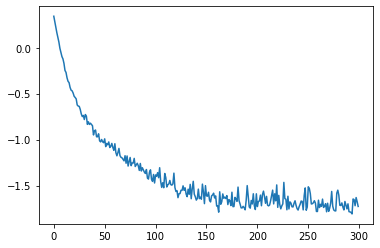

In [847]:
losses = torch.tensor(losses)
losses = losses.view(-1, 10)
losses_mean = losses.mean(1)
losses_log10 = losses_mean.log10()
plt.plot(losses_log10)

Layer 2: mean = 0.40 | std = 0.61 | negative = 53.41389083862305%
Layer 5: mean = 0.37 | std = 0.57 | negative = 51.849342346191406%
Layer 10: mean = 0.02 | std = 0.75 | saturation = 10.62%


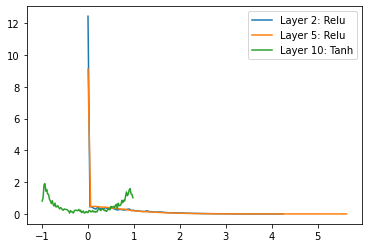

In [848]:
# Look at activations

for i, layer in enumerate(model.layers): 
    if isinstance(layer, Tanh) or isinstance(layer, Relu): 
        t = layer.out
        counts, bin_edges = torch.histogram(t, density=True)
        plt.plot(bin_edges[:-1].detach(), counts.detach(), label=f"Layer {i}: {layer}")

        if isinstance(layer, Tanh):
            print(f"Layer {i}: mean = {layer.out.mean():.2f} | std = {layer.out.std():.2f} | saturation = {sum([counts[j] for j, bins in enumerate(bin_edges[1:]) if abs(bins) > 0.95])/sum(counts) * 100:.2f}%")
        elif isinstance(layer, Relu): 
            print(f"Layer {i}: mean = {layer.out.mean():.2f} | std = {layer.out.std():.2f} | negative = {counts[0]/sum(counts) * 100}%")

plt.legend()

Layer 2 Relu : mean = +0.000000 | std = 4.954518e-05
Layer 5 Relu : mean = +0.000000 | std = 3.891398e-05
Layer 10 Tanh : mean = -0.000006 | std = 4.274650e-04


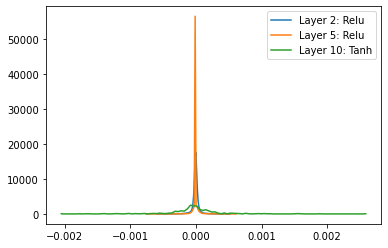

In [838]:
# Look at gradients of activations

plt.figure()
for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, Tanh) or isinstance(layer, Relu): 
        t = layer.out.grad
        counts, bin_edges = torch.histogram(t, density=True)
        plt.plot(bin_edges[:-1].detach(), counts.detach(), label=f"Layer {i}: {layer}")
        print(f"Layer {i} {layer} : mean = {t.mean():+f} | std = {t.std():e}")

plt.legend()

0 (12, 25) : mean = -0.000003 | std = 2.969341e-03
3 (12, 300) : mean = +0.000165 | std = 1.710788e-03
6 (768, 30) : mean = -0.000005 | std = 7.884415e-04
9 (30, 10) : mean = +0.000000 | std = 1.218596e-03


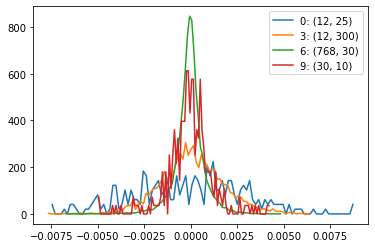

In [849]:
# Look at gradients of parameters

plt.figure()
for i,p in enumerate(params):
    if p.squeeze().ndim >= 2:
        t = p.grad
        counts, bin_edges = torch.histogram(t, density=True)
        plt.plot(bin_edges[:-1].detach(), counts.detach(), label=f"{i}: {tuple(p.shape)}")
        print(f"{i} {tuple(p.shape)} : mean = {t.mean():+f} | std = {t.std():e}")

plt.legend()

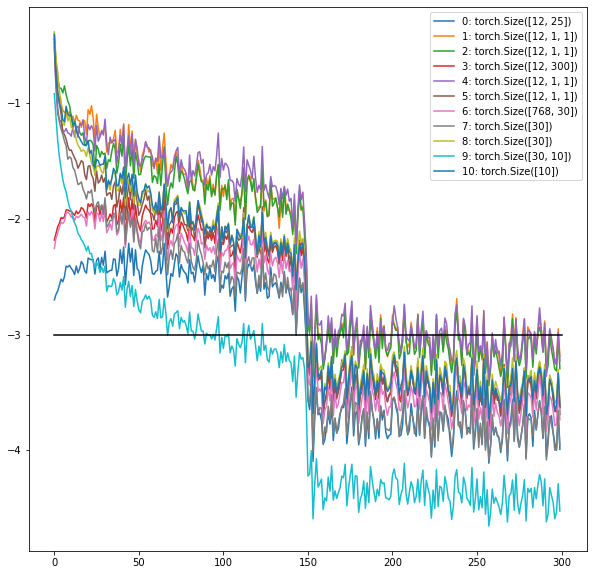

In [840]:
# Look at update rates of parameters 

plt.figure(figsize=(10, 10))
ud_tensor = torch.tensor(ud)
ud_tensor = ud_tensor.view(ud_tensor.shape[0]//10, 10, ud_tensor.shape[1])
ud_tensor = ud_tensor.mean(dim=1)
for j, p in enumerate(params):
    plt.plot(ud_tensor[:, j], label=f"{j}: {p.shape}")

plt.plot([0, ud_tensor.shape[0]], [-3, -3], 'k')
plt.legend()


In [852]:
# measure train vs. test set 

@torch.no_grad()
def split_loss(split): 
    X, Y = {
        'train': (Xtr, Ytr),
        'test': (Xte, Yte)
    }[split]
    
    # forward pass
    logits = model(X) 
    loss = F.cross_entropy(logits, Y)
    
    return loss 

# first set BatchNorm to run-mode
for layer in model.layers: 
    layer.track_running_stats = False

print(f"Training Loss = {split_loss('train')}")
print(f"Test Loss = {split_loss('test')}")

Training Loss = 0.01798202469944954
Test Loss = 0.13048583269119263


In [834]:
# Measure rejection rate and error rate
threshold = 0.65   # this is the minimum acceptable difference between the top prob and the next highest prob to be accepted. Anything below this will be rejected 
total_ct = len(Xte)

for layer in model.layers: 
    layer.track_running_stats = False

@torch.no_grad()
def get_rejections_errors(split, threshold): 
    
    errors = 0
    rejections = 0
    X, Y = {"training": (Xtr, Ytr),
            "test": (Xte, Yte)
           }[split]
    
    # iterate through every test sample and measure rejection and errors: 
    total_ct = len(X)
    for i in range(total_ct): 
        ix = torch.tensor((i, ))
        x = X[ix]
        y = Y[ix]

        logits = model(x)
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        select = torch.max(probs, 1)

        sorted, indices = torch.sort(probs)
        if (sorted[0,-1] - sorted[0,-2]) < threshold: 
            rejections += 1
            continue

        # if not rejected, check errors
        if abs(select.indices - y) > 0: 
            errors += 1

    print(f" -------------------- {split} set -----------------------")
    print(f"Rejections = {rejections}, Rejection rate = {(rejections/total_ct):.3f}")
    print(f"Errors = {errors}, Error rate = {(errors/total_ct):.3f}")

get_rejections_errors("training", threshold)
get_rejections_errors("test", threshold)

 -------------------- training set -----------------------
Rejections = 58, Rejection rate = 0.008
Errors = 1, Error rate = 0.000
 -------------------- test set -----------------------
Rejections = 131, Rejection rate = 0.065
Errors = 24, Error rate = 0.012


Difference between 1st and 2nd probs: 1.00
Difference between 1st and 2nd probs: 1.00
Difference between 1st and 2nd probs: 1.00
Difference between 1st and 2nd probs: 0.83
Difference between 1st and 2nd probs: 0.98
Difference between 1st and 2nd probs: 0.99
Difference between 1st and 2nd probs: 1.00
Difference between 1st and 2nd probs: 1.00
Difference between 1st and 2nd probs: 0.02


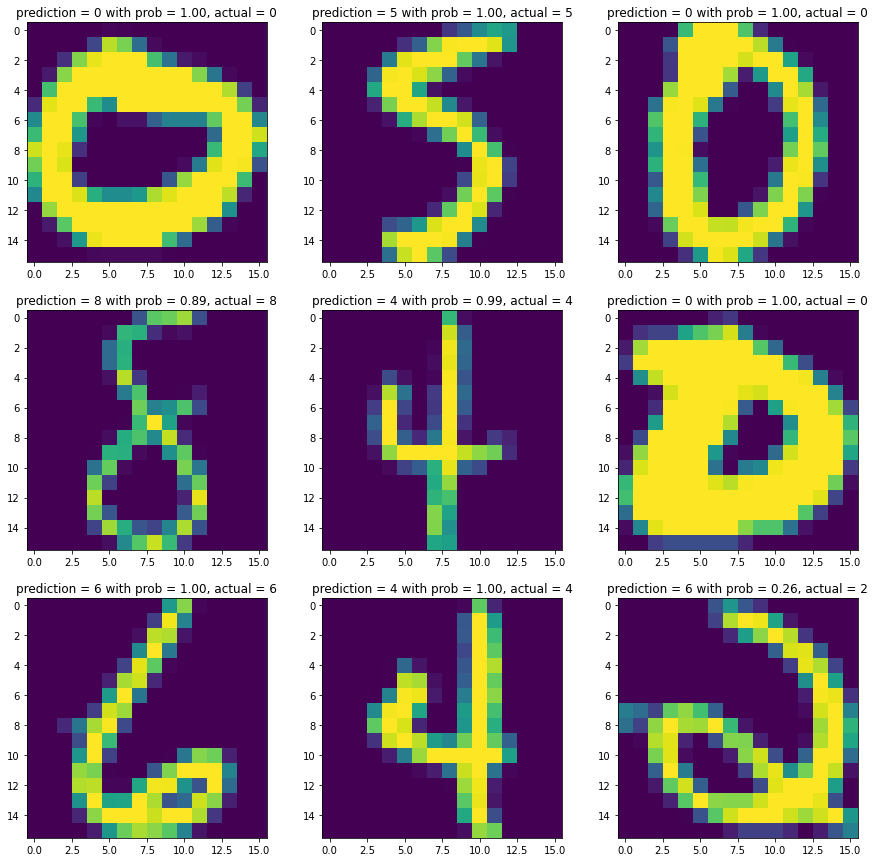

In [808]:
# Sample the model

# first set BatchNorm to run-mode
for layer in model.layers: 
    layer.track_running_stats = False

fig, axs = plt.subplots(3,3)
fig.set_size_inches(15, 15)

for i in range(9):
    # sample the model 
    ix = torch.randint(0, Xte.shape[0], (1, ))
    x = Xte[ix]
    y = Yte[ix]

    logits = model(x)
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    select = torch.max(probs, 1)
    
    row = i//3
    col = i % 3
    axs[row][col].imshow(x.squeeze())
    axs[row][col].title.set_text(f"prediction = {select.indices.item()} with prob = {select.values.item():.2f}, actual = {y.item()}")
    
    sorted, indices = torch.sort(probs)
    print(f"Difference between 1st and 2nd probs: {(sorted[0,-1] - sorted[0,-2]):.2f}")


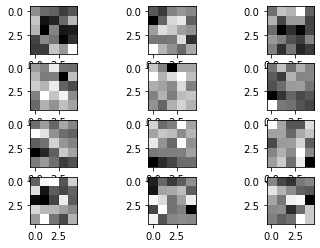

In [661]:
# Examine filters in Conv1

filters1 = model.layers[0].weight
fig, axs = plt.subplots(4,3)
for i in range(filters1.shape[0]):
    row = i//3
    col = i%3
    axs[row][col].imshow(filters1[i].view(5,5).detach(), cmap='gray')

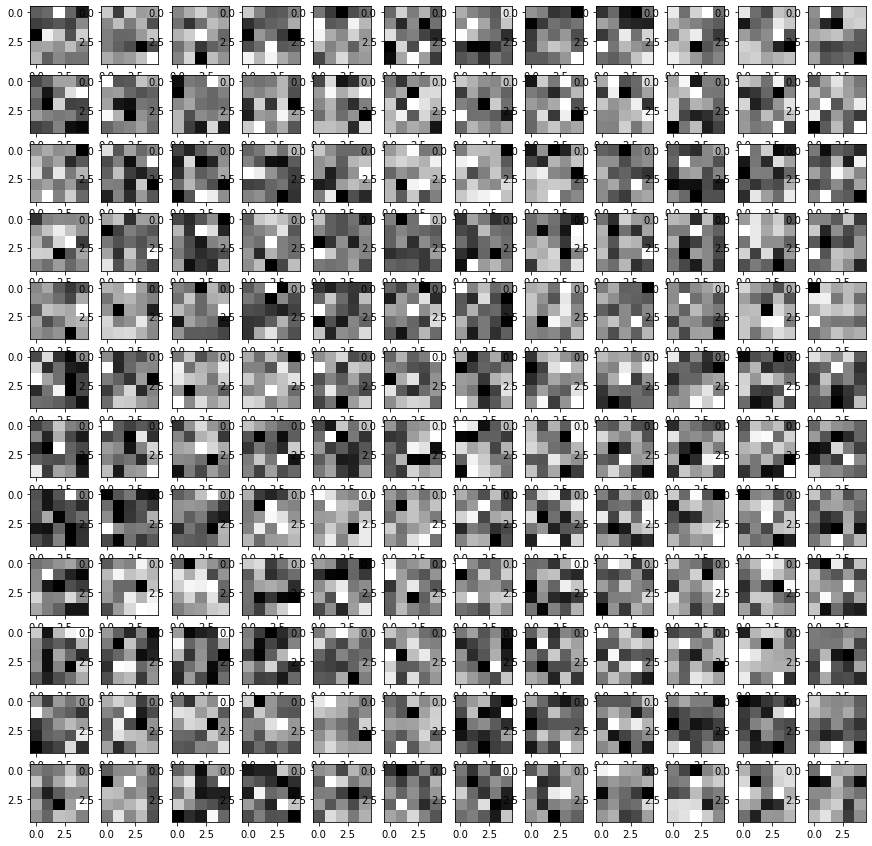

In [663]:
# Examine filters in Conv2

filters2 = model.layers[3].weight
fig, axs = plt.subplots(12, 12)
fig.set_size_inches(15, 15)
for i in range(12*12):
    row = i//12
    col = i%12
    axs[row][col].imshow(filters2[row][12*col:12*col+25].view(5,5).detach(), cmap='gray')

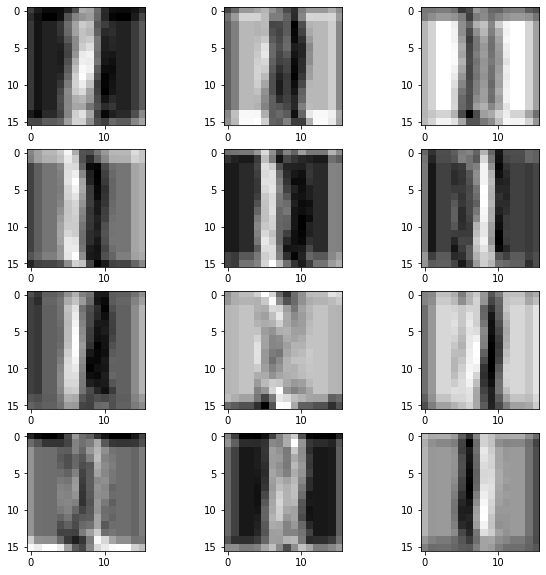

In [787]:
# Plot feature maps of conv1

feature1 = model.layers[0].out
feature1 = feature1.squeeze()
fig, axs = plt.subplots(4,3)
fig.set_size_inches(10, 10)
for i in range(feature1.shape[0]):
    row = i//3
    col = i%3
    axs[row][col].imshow(feature1[i].view(16,16).detach(), cmap='gray')

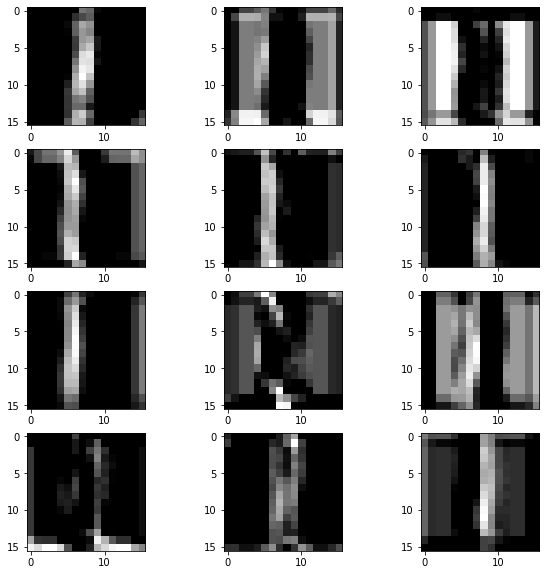

In [788]:
# Plot feature maps of Conv2 

feature2 = model.layers[2].out.squeeze()
fig, axes = plt.subplots(4,3)
fig.set_size_inches(10, 10)
for i in range(feature2.shape[0]):
    row = i // 3
    col = i % 3
    axes[row][col].imshow(feature2[i].detach(), cmap='gray')



# Performance Log 
- 1st Pass: (Conv1 (12x5x5, s1, p0), Conv2 (12x5x5, s1, p0), FC1 (30), FC2 (10)), batch_size = 32: Definitely overfitting. Training loss = 0.02, test loss = 0.18
- 2nd Pass: (Conv1 (12x5x5, s1, p0), Conv2 (12x5x5, s1, p0), MaxPool (s2, p0), FC1 (30), FC2 (10), batch_size = 32: Still overfitting, but better test performance. Training loss = 0.02, test loss = 0.133. For a threshold of 65%, training set achieves 1.1% and an error rate of 0.1%, while the test set achieves 6.8% and an error rate of 1.0%.
- 3rd Pass: Replaced Tanh with Relu on Conv layers. No significant improvement. Training Loss = 0.013, Test loss = 0.149. Not much difference, but now the feature makes look much more recognizable to the human eye (a lot more obvious contrast between black and white). 
- 4th Pass: Added BatchNorm2d before Relu on Conv layers. Training loss = 0.013, Test loss = 0.138. Not much difference. 
- 5th Pass: Increased training runs from 2000 -> 3000, Training Loss = 0.016, Test loss = 0.125. Seems like there's more to be gained by longer training. 
- 6th Pass: Changed Conv1 and Conv2 layers from 5x5 to 3x3 kernels, with padding = 1. Training Loss = 0.02, Test Loss = 0.138. Seems to be degraded performance. 
- 7th Pass: Reverted Conv1 and Conv2. Added Conv3 (12x2x2, s1, p0), Conv4 (12x2x2, s1, p0), MaxPool(s2, p0) after first set of Conv layers. Training loss = 0.018, Test loss = 0.137. Degradation compared to original model. 
- 8th Pass: Removed Conv3 and Conv4. Added an extra 30-unit FC layer after FC1, also with 30 hidden units. No improvement.
- DOE on n_hidden1: optimum found to be 30 units. 
